# Accessibility Analysis

- This analysis will measure accessibility to schools and hospitals
- origins are derived from 100m grid blocks coming from WorldPop
- the accessibility measure is the distance to the nearest facility in meters

## Inputs:

#### origins: derived from a WorldPOP raster using the 'Raster pixels to Points' tool in QGIS 3, and saved as a shapefile
#### destinations: The combination of POIs from Overpass as points and centroids of polygons called through the GOSTNets OSMNX_POIs library.
#### The admin AOI will be used to create a bounding box to download the road network via OSMNX


### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.ops import split, unary_union
from shapely.geometry import box, Point

import matplotlib.pyplot as plt

In [3]:
# Get reference to GOSTNets
sys.path.append(r'C:\repos\GOSTnets')
import GOSTnets as gn

In [4]:
from GOSTnets.fetch_pois import *

### Define folders and files

In [5]:
inputFolder = r'input_folder'
# define output folder
outputFolder = r'output_folder'
# define road graph
roadGraph = os.path.join(inputFolder, "OSM_Roads.pickle")

In [6]:
city_name = 'agadez'

In [7]:
origins_file = os.path.join(inputFolder, "agadez_world_pop_pts.shp")

In [8]:
# import extent
city_extent = gpd.read_file("../admin/Agadez_AOI_4326.shp")

In [9]:
# make sure crs is 4326
print(city_extent.crs)

epsg:4326


In [10]:
extent = box(*city_extent.total_bounds)

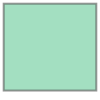

In [11]:
extent

## We will extract OSM POIs

In [12]:
school_tags = {'amenity':['school', 'kindergarten', 'university', 'college']}
health_tags = {'amenity':['clinic', 'pharmacy', 'hospital', 'health']}

In [13]:
tag_dictionary = {'schools': school_tags, 'health': health_tags}

In [14]:
queries = {}
for tags in tag_dictionary.items():
    print(tags[0])
    # create the OsmObject
    queries[tags[0]] = OsmObject(f'{tags[0]}', extent, tags[1])
query_results_gpd_dict = {}
for query in queries.items():
    print(query)
    query[1].GenerateOSMPOIs()
    query[1].RemoveDupes(0.0005)
    
    query_results = query[1].df[['amenity','geometry','name']]
    
    # convert to GeoDataFrame
    query_results_gpd = gpd.GeoDataFrame(query_results, crs = "epsg:4326", geometry = 'geometry')
    query_results_gpd.to_file(outputFolder + f'/osm_infrastructure/osm_{query[0]}.shp')
    
    #save result in query_results_gpd_dict 
    query_results_gpd_dict[query[0]] = query_results_gpd

schools
health
('schools', <GOSTnets.fetch_pois.OsmObject object at 0x0000011F2BCF5288>)


C:\repos\GOSTnets\GOSTnets\fetch_pois.py:75: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons['geometry'] = polygons.centroid
C:\Users\war-machine\Anaconda2\envs\gostnets2\lib\site-packages\geopandas\geoseries.py:158: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\repos\GOSTnets\GOSTnets\fetch_pois.py:91: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['buffer'] = gdf['geometry'].buffer(buf_width)


('health', <GOSTnets.fetch_pois.OsmObject object at 0x0000011F2BCF5308>)


C:\repos\GOSTnets\GOSTnets\fetch_pois.py:75: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons['geometry'] = polygons.centroid
C:\Users\war-machine\Anaconda2\envs\gostnets2\lib\site-packages\geopandas\geoseries.py:158: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\repos\GOSTnets\GOSTnets\fetch_pois.py:91: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['buffer'] = gdf['geometry'].buffer(buf_width)


## We will extract the Roads and convert into a graph

In [15]:
# This is the section where we can adjust the road speeds
if not os.path.exists(roadGraph):
    extent = box(*city_extent.total_bounds)
    G = ox.graph_from_polygon(extent, network_type = 'drive_service')
    # This is how time is calculated from the OSMNX length attribute
    G = gn.convert_network_to_time(G, 'length')
    # save the largerst subgraph
   
    # compatible with NetworkX 2.4
    list_of_subgraphs = list(G.subgraph(c).copy() for c in nx.strongly_connected_components(G))
    max_graph = None
    max_edges = 0
    for i in list_of_subgraphs:
        if i.number_of_edges() > max_edges:
            max_edges = i.number_of_edges()
            max_graph = i

    # set your graph equal to the largest sub-graph
    G = max_graph

    nx.write_gpickle(G, roadGraph)
else:
    G = nx.read_gpickle(roadGraph)    
    G = gn.convert_network_to_time(G, 'length')

C:\Users\war-machine\Anaconda2\envs\gostnets2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Inspect the road graph as a shapefile

In [16]:
roads = gn.edge_gdf_from_graph(G)

In [17]:
pd.set_option('display.max_columns', None)  

In [18]:
roads[:2]

,stnode,endnode,time,length,name,mode,service,osmid,highway,ref,junction,bridge,oneway,oneway,geometry
0,277869555,5494883319,2.81880,15.660,NaN,drive,NaN,571827965,residential,NaN,NaN,NaN,True,True,"LINESTRING (7.96208 16.94402, 7.96214 16.94389)"
1,277869555,2304927073,83.67768,464.876,NaN,drive,NaN,"[221460464, 445817499]",residential,NaN,NaN,NaN,False,False,"LINESTRING (7.96208 16.94402, 7.96170 16.94441..."


In [19]:
if not os.path.exists(outputFolder + '/OSM_Roads/OSM_Roads.shp'):
    #roads['oneway'] = roads.oneway.astype(int)
    roads = roads[['length','time','mode','geometry']]
    roads.to_file(outputFolder + '/OSM_Roads')

C:\Users\war-machine\Anaconda2\envs\gostnets2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Snap origins to the road graph using advanced snapping

In [20]:
# insert origins
origins = gpd.read_file(origins_file)

In [21]:
origins['osmid'] = 1110000000 + origins.index
origins

,VALUE,geometry,osmid
0,9.319211,POINT (8.01583 17.01917),1110000000
1,9.290095,POINT (8.01250 17.01833),1110000001
2,13.684067,POINT (8.01583 17.01833),1110000002
3,9.652495,POINT (8.01667 17.01833),1110000003
4,9.302252,POINT (8.01417 17.01750),1110000004
...,...,...,...
3920,11.794782,POINT (7.96667 16.92750),1110003920
3921,19.526073,POINT (7.94667 16.92667),1110003921
3922,17.730124,POINT (7.94750 16.92667),1110003922
3923,9.599254,POINT (7.95083 16.92667),1110003923


In [22]:
# find graph utm zone
G_utm = gn.utm_of_graph(G)
G_utm

C:\Users\war-machine\Anaconda2\envs\gostnets2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'+proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

In [23]:
%%time
G2, pois_meter, new_footway_edges = gn.advanced_snap(G, origins, u_tag = 'stnode', v_tag = 'endnode', node_key_col='osmid', poi_key_col='osmid', path=None, threshold=2000, measure_crs=G_utm)

Building rtree...
Projecting POIs to the network...
Updating internal nodes...
print _new_nodes
                            geometry        highway       osmid
0     POINT (395169.514 1881954.635)  projected_pap  9990000000
1     POINT (394930.777 1881817.039)  projected_pap  9990000001
2     POINT (395189.752 1881824.353)  projected_pap  9990000002
3     POINT (395191.274 1881820.352)  projected_pap  9990000003
4     POINT (395062.370 1881714.841)  projected_pap  9990000004
...                              ...            ...         ...
3258  POINT (390431.711 1872983.311)  projected_pap  9990003258
3259  POINT (390621.940 1872941.486)  projected_pap  9990003259
3260  POINT (390245.318 1872982.588)  projected_pap  9990003260
3261  POINT (390211.684 1872979.382)  projected_pap  9990003261
3262  POINT (390203.938 1872979.205)  projected_pap  9990003262

[3263 rows x 3 columns]
Updating internal edges...
Updating external links...
Remove edge projections greater than threshold: 29/3925 (

In [24]:
originNodes_list = list(origins['osmid'])

C:\Users\war-machine\Anaconda2\envs\gostnets2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Snap destinations to the road graph

In [25]:
snapped_destinations_dict = {}
for results_gpd in query_results_gpd_dict.items():
    snapped_destinations = gn.pandana_snap(G, query_results_gpd_dict[results_gpd[0]])
    snapped_destinations_dict[results_gpd[0]] = list(snapped_destinations['NN'].unique())

In [26]:
snapped_destinations_dict

{'schools': [2305699803,
  2286189057,
  2285800350,
  2285152983,
  2304927070,
  2285800151,
  5171069369,
  2305151942,
  2304905388,
  708526075,
  4425787610,
  2285800681,
  2285799557,
  2305699825,
  2305700023,
  2305038646,
  2092447300,
  2092447263,
  2304905541,
  2092447229,
  2304870681,
  2305038734,
  5171164968,
  2306530707,
  2305011164,
  2285867367,
  2609829606,
  2304870679,
  4431599533,
  3167149086,
  708526088,
  2051181244,
  2285801617,
  2304905528,
  2304947733,
  4752556739,
  2305699635,
  2285800517,
  2304905519,
  7415835139],
 'health': [2285149440,
  2285801753,
  2285867396,
  4418911600,
  2305699284,
  2051172760,
  2051172693,
  2285149452,
  2609829597,
  2285799664,
  2305038672]}

## Isochrones processing

In [27]:
threshold_list = [800,1600,3200]
for destinations in snapped_destinations_dict.items():
    #perform isochrones processing
    for threshold in threshold_list:
        print(threshold)
        iso_gdf = gn.make_iso_polys(G2, destinations[1], [threshold], edge_buff=300, node_buff=300, weight = 'length', measure_crs = G_utm)
        dissolved = iso_gdf.dissolve(by="thresh")
        gdf_out = dissolved.explode()
        gdf_out2 = gdf_out.reset_index()
        # save file
        gdf_out2.to_file(outputFolder + f'/{city_name}_AOI_accessibility_{destinations[0]}_isochrones_{threshold}m.shp')


800
merge all edges and nodes
unary_union
1600
merge all edges and nodes
unary_union
3200
merge all edges and nodes
unary_union
800
merge all edges and nodes
unary_union
1600
merge all edges and nodes
unary_union
3200
merge all edges and nodes
unary_union
